In [1]:
import pandas as pd
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from matplotlib.colors import CenteredNorm
from matplotlib.patches import Rectangle
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
plt.rcParams.update({'font.size':20})

In [2]:
models_dir = 'corrected_models' # cell_collective OR corrected_models

QCF = pd.read_csv(f'data/{models_dir}/quasicoherence_fuzzy_withsource.csv')
QCN = pd.read_csv(f'data/{models_dir}/quasicoherence_nonfuzzy_withsource.csv')
QCFNS = pd.read_csv(f'data/{models_dir}/quasicoherence_fuzzy_sourceless.csv')
QCNS = pd.read_csv(f'data/{models_dir}/quasicoherence_nonfuzzy_sourceless.csv')
FHD = pd.read_csv(f'data/{models_dir}/final_hamming_distance_withsource.csv')
FHDNS = pd.read_csv(f'data/{models_dir}/final_hamming_distance_sourceless.csv')
DC = pd.read_csv(f'data/{models_dir}/derrida_coefficients.csv')
QC = pd.read_csv('data/model_categories.csv')

In [3]:
QC = QC.merge(QCN)
QC = QC.merge(QCF)
QC = QC.merge(QCNS)
QC = QC.merge(QCFNS)
QC = QC.merge(FHD)
QC = QC.merge(FHDNS)
QC = QC.merge(DC)
QC.columns = ['name', 'category',
              'SQC', 'AQC', 
              'SFQC', 'AFQC', 
              'SQCNS', 'AQCNS', 
              'SFQCNS', 'AFQCNS',
              'SFHD', 'AFHD', 
              'SFHDNS', 'AFHDNS',
              'SDC', 'ADC', 
              'SDCNS', 'ADCNS']



N = []
NS = []
for name in sorted(QC['name']):
    with open(f'models/{models_dir}/{name}.txt') as f:
        nt = 0
        ns = 0
        for row in f:
            if row[0] == '#':
                continue
            nt += 1
            if row.split(',')[0].strip() == row.split(',')[1].strip():
                ns += 1
        N.append(nt)
        NS.append(ns)

NDF = pd.DataFrame({
    'name': sorted(QC['name']),
    'N': N,
    'NS': NS,
})

QC=QC.merge(NDF)

# Fragility = 
# long-term difference in node avg. values after initial 1-node perturbation
QC['AF'] = (1-QC['AFQC'])*(QC['N'])
QC['SF'] = (1-QC['SFQC'])*(QC['N'])
QC['AFNS'] = (1-QC['AFQCNS'])*(QC['N']-QC['NS'])
QC['SFNS'] = (1-QC['SFQCNS'])*(QC['N']-QC['NS'])

QC.sort_values(by=['name'])

,name,category,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,SFHD,AFHD,SFHDNS,AFHDNS,SDC,ADC,SDCNS,ADCNS,N,NS,AF,SF,AFNS,SFNS
0,Apoptosis Network,Signal Transduction (Stress/Damage and Homeost...,0.900273,0.912039,0.975298,0.976660,0.946441,0.958810,0.988704,0.991545,1.448945,1.116427,0.829725,0.458211,1.01185,1.029840,0.929947,0.956978,41,2,0.956940,1.012782,0.329745,0.440544
1,Arabidopsis thaliana Cell Cycle,Cell Cycle,1.000000,1.000000,0.999986,1.000000,1.000000,1.000000,0.999986,1.000000,1.710851,0.000000,1.710851,0.000000,1.27217,1.221887,1.281474,1.213676,14,0,0.000000,0.000196,0.000000,0.000196
2,Aurora Kinase A in Neuroblastoma,Cancer,0.762487,0.777443,0.943056,0.940945,0.923011,0.941116,0.959213,0.952553,1.833380,1.358292,1.350772,0.901518,1.05042,1.060642,0.994890,1.002820,23,4,1.358265,1.309712,0.901493,0.774953
3,B bronchiseptica and T retortaeformis coinfection,Infection and Microbiome,0.911819,0.924596,0.991513,0.988200,0.929354,0.942377,0.993036,0.990140,0.453737,0.625389,0.366094,0.512708,1.00035,0.992047,0.971029,0.960888,53,1,0.625400,0.449811,0.512720,0.362128
4,B cell differentiation,Development and Differentiation,0.734818,0.739509,0.957467,0.956148,0.950941,0.957012,0.985660,0.987539,0.935727,0.964745,0.243788,0.211835,1.00034,1.012881,0.702522,0.743415,22,5,0.964744,0.935726,0.211837,0.243780
7,BT474 Breast Cell Line Long-term ErbB Network,Cancer Drug Response,0.647967,0.628817,0.972706,0.970826,0.818484,0.794295,0.985468,0.983001,0.655050,0.700183,0.276105,0.322989,0.94386,0.916887,0.802654,0.790684,24,5,0.700176,0.655056,0.322981,0.276108
8,BT474 Breast Cell Line Short-term ErbB Network,Cancer Drug Response,0.640525,0.603600,0.964036,0.958998,0.931673,0.877964,0.989362,0.982969,0.575425,0.656025,0.117018,0.187345,0.76141,0.823760,0.375278,0.551845,16,5,0.656032,0.575424,0.187341,0.117018
5,Bordetella bronchiseptica,Infection and Microbiome,0.971830,0.967976,0.994143,0.998628,0.971830,0.967976,0.994143,0.998628,0.194606,0.045261,0.194606,0.045261,1.01373,0.992839,1.015182,0.990389,33,0,0.045276,0.193281,0.045276,0.193281
6,Bortezomib Responses in U266 Human Myeloma Cells,Cancer Drug Response,0.984191,0.979755,0.998541,0.995128,0.999103,0.994600,0.999471,0.996620,0.097725,0.326406,0.034927,0.223103,0.91466,0.953433,0.885809,0.934173,67,1,0.326424,0.097753,0.223080,0.034914
10,Budding Yeast Cell Cycle,Cell Cycle,0.723720,0.780300,0.952530,0.952999,0.904650,0.975375,0.986567,0.992089,1.053010,0.940096,0.328550,0.126675,1.01288,1.016300,0.828460,0.854380,20,4,0.940020,0.949400,0.126576,0.214928


In [4]:
class PlotVar():
    _label_dict ={
        'SFQC':r'$\tilde{q}_{s,p}$ : sync. fuzzy quasicoherence',
        'AFQC':r'$\tilde{q}_{a,p}$ : async. fuzzy quasicoherence',
        'SFQCNS':r'$\tilde{q}_{s,f}$ : sync. fuzzy quasicoherence (fixed source)',
        'AFQCNS':r'$\tilde{q}_{a,f}$ : async. fuzzy quasicoherence (fixed source)',
        'SQC':r'$q_{s,p}$ : sync. quasicoherence',
        'AQC':r'$q_{a,p}$ : async. quasicoherence',
        'SQCNS':r'$q_{s,f}$ : sync. quasicoherence (fixed source)',
        'AQCNS':r'$q_{a,f}$ : async. quasicoherence (fixed source)',
        'SFHD':r'$h^{\infty}_{s,p}$ : sync. final Hamming distance',
        'AFHD':r'$h^{\infty}_{a,p}$ : async. final Hamming distance',
        'SFHDNS':r'$h^{\infty}_{s,f}$ : sync. final Hamming distance (fixed source)',
        'AFHDNS':r'$h^{\infty}_{a,f}$ : async. final Hamming distance (fixed source)',
        'SF':r'$\varphi_{s,p}$ : sync. fragility',
        'AF':r'$\varphi_{a,p}$ : async. fragility',
        'SFNS':r'$\varphi_{s,f}$ : sync. fragility (fixed source)',
        'AFNS':r'$\varphi_{a,f}$ : async. fragility (fixed source)',
        'SDC':r'$\delta_{s,p}$ : sync. Derrida coefficient',
        'ADC':r'$\delta_{a,p}$ : async. Derrida coefficient',
        'SDCNS':r'$\delta_{s,f}$ : sync. Derrida coefficient (fixed source)',
        'ADCNS':r'$\delta_{a,f}$ : async. Derrida coefficient (fixed source)',
    }
    
    def __init__(self,name:str,minval:float,maxval:float):
        self.name = name
        self.minval = minval
        self.maxval = maxval
        self.label = self._label_dict[name]

In [5]:
highlight_marker_size = 350
highlight_alpha = 1

color_list = ['#88CCEE', '#44AA99', '#117733', '#433685', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#4141FF', '#FF66FF'] # tol_muted scheme

highlight_dict = {
    'Apoptosis Network':(color_list[0],highlight_marker_size,highlight_alpha),
    'Arabidopsis thaliana Cell Cycle':(color_list[1],highlight_marker_size,highlight_alpha),
    'Aurora Kinase A in Neuroblastoma':(color_list[2],highlight_marker_size,highlight_alpha),
    'Cell Cycle Transcription by Coupled CDK and Network Oscillators':(color_list[10],highlight_marker_size,highlight_alpha),
    'Colitis-associated colon cancer': (color_list[5],highlight_marker_size,highlight_alpha),
    'Cortical Area Development':(color_list[4],highlight_marker_size,highlight_alpha),
    'Human Gonadal Sex Determination': (color_list[3],highlight_marker_size,highlight_alpha),
    'Metabolic Interactions in the Gut Microbiome':(color_list[6],highlight_marker_size,highlight_alpha),
    'Regulation of the L-arabinose operon of Escherichia coli':(color_list[7],highlight_marker_size,highlight_alpha),
    'Tumour Cell Invasion and Migration': (color_list[8],highlight_marker_size,highlight_alpha),
    'Signal Transduction in Fibroblasts': (color_list[9],highlight_marker_size,highlight_alpha),
}
default_highlight = ('black',250,0.2)

category_symbol_dict = {
    'Cancer': 'X',
    'Cancer Drug Response': 'P',
    'Cell Cycle': 'o',
    'Development and Differentiation': 'd',
    'Infection and Microbiome': 'p',
    'Metabolism': 'H',
    'Signal Transduction (Immune System Cells)': '^',
    'Signal Transduction (Other)': 'v',
    'Signal Transduction (Drosophila)': '>',
    'Signal Transduction (Stress/Damage and Homeostasis)': '<',
}

def hc(df):
    return [highlight_dict.get(name, default_highlight)[0] for name in df['name']]
def hs(df):
    return [highlight_dict.get(name, default_highlight)[1] for name in df['name']]
def halpha(df):
    return [highlight_dict.get(name, default_highlight)[2] for name in df['name']]

groups = QC.groupby('category')

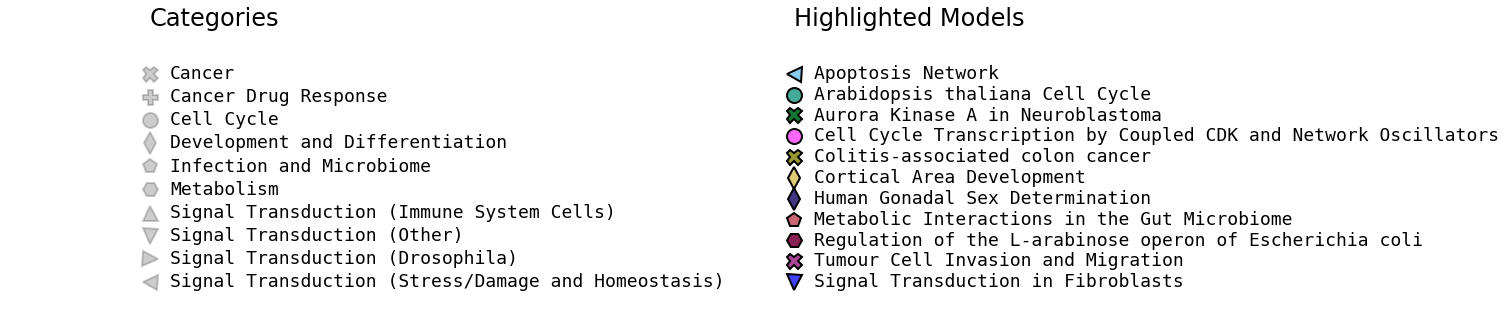

In [6]:
text_style = dict(horizontalalignment='left', verticalalignment='center',
                  fontsize=18, fontfamily='monospace')
marker_style = dict(linestyle=':', markersize=15)


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()
    ax.invert_yaxis()
    
fig,ax = plt.subplots(1,2,figsize=(20,5))
fig.set_facecolor('white')
# fig.suptitle('Shared Legend', fontsize=24)
# fig.subplots_adjust(right=-4,left=-5)

for y, (name, marker) in enumerate(category_symbol_dict.items()):
    ax[0].text(0.01, y, name, **text_style)
    ax[0].plot([y] * 1, c=default_highlight[0],alpha=default_highlight[2], marker=marker,markeredgewidth=2,markeredgecolor='k', **marker_style)
for y, (name, marker_data) in enumerate(highlight_dict.items()):
    ax[1].text(0.01, y, name, **text_style)
    ax[1].plot([y] * 1, c=marker_data[0], alpha=marker_data[2], marker=category_symbol_dict[QC[QC['name']==name]['category'].values[0]],markeredgewidth=2,markeredgecolor='k', **marker_style)
ax[0].set_title('Categories',horizontalalignment='left')
ax[1].set_title('Highlighted Models',horizontalalignment='left')
format_axes(ax[0])
format_axes(ax[1])

fig.tight_layout()
plt.savefig(f'./data/{models_dir}/figures/shared_legend.png',bbox_inches='tight')
plt.savefig(f'./data/{models_dir}/figures/shared_legend.pdf',bbox_inches='tight')
plt.show()

In [7]:
def comparison_plots(vars):
    icount = len(vars)
    jcount = len(vars[0])

    fig = plt.figure(figsize=(10*jcount,10*icount))
    fig.set_facecolor('white')

    figs = fig.subfigures(icount,jcount)
    figs = np.reshape(figs, (icount,jcount)) # always treat as 2d array, even when only 1 col or row

    stretch_factor = 6
    for i,j in it.product(range(icount),range(jcount)):
        px,py = vars[i][j]
        vx,vy = px.name,py.name
        xmin,xmax = px.minval,px.maxval #lims[i][j][0]
        ymin,ymax = py.minval,py.maxval #lims[i][j][1]
        axd = figs[i,j].subplot_mosaic([
                                ['x0','.' ],
                                ['s0','y0'],
                                
                                ],                          
                                gridspec_kw={'width_ratios':[stretch_factor,1],
                                            'height_ratios':[1,stretch_factor],
                                            },
                                )

        for name,group in groups:
            axd['s0'].scatter(group[vx],group[vy],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
        axd['s0'].axline((1,1),slope=1,linestyle='--',color='k')
        axd['s0'].set_xlabel(px.label)
        axd['s0'].set_ylabel(py.label)
        axd['s0'].set_xlim(xmin,xmax)
        axd['s0'].set_ylim(xmin,xmax)
        axd['x0'].sharex(axd['s0'])
        axd['y0'].sharey(axd['s0'])
        axd['x0'].tick_params(axis="x", labelbottom=False)
        axd['y0'].tick_params(axis="x", labelbottom=False)
        axd['x0'].tick_params(axis="y", labelleft=False)
        axd['y0'].tick_params(axis="y", labelleft=False)
        # axd['x0'].hist(QC[vx],bins=20,range=(xmin,xmax),color='red')
        dx = gaussian_kde(QC[vx])
        lx = np.linspace(xmin,xmax,1000)
        dlx = dx(lx)
        axd['x0'].fill_between(lx,dlx,color='lightgrey')
        axd['x0'].vlines(np.quantile(QC[vx],[0.0,0.25,0.5,0.75,1.0]),0,np.array([0.25,0.5,1.0,0.5,0.25])*max(dlx)/2,linewidth=5,color='red')
        dy = gaussian_kde(QC[vy])
        ly = np.linspace(ymin,ymax,1000)
        dly = dy(ly)
        axd['y0'].fill_betweenx(ly,dly,color='lightgrey')
        axd['y0'].hlines(np.quantile(QC[vy],[0.0,0.25,0.5,0.75,1.0]),0,np.array([0.25,0.5,1.0,0.5,0.25])*max(dly)/2,linewidth=5,color='red')
        # axd['y0'].hist(QC[vy],density=True,orientation='horizontal',bins=20,range=(ymin,ymax),color='grey')
        figs[i,j].subplots_adjust(hspace=0.01,wspace=0.01)
    fig.subplots_adjust(bottom=0.0,left=0.05)
    return fig


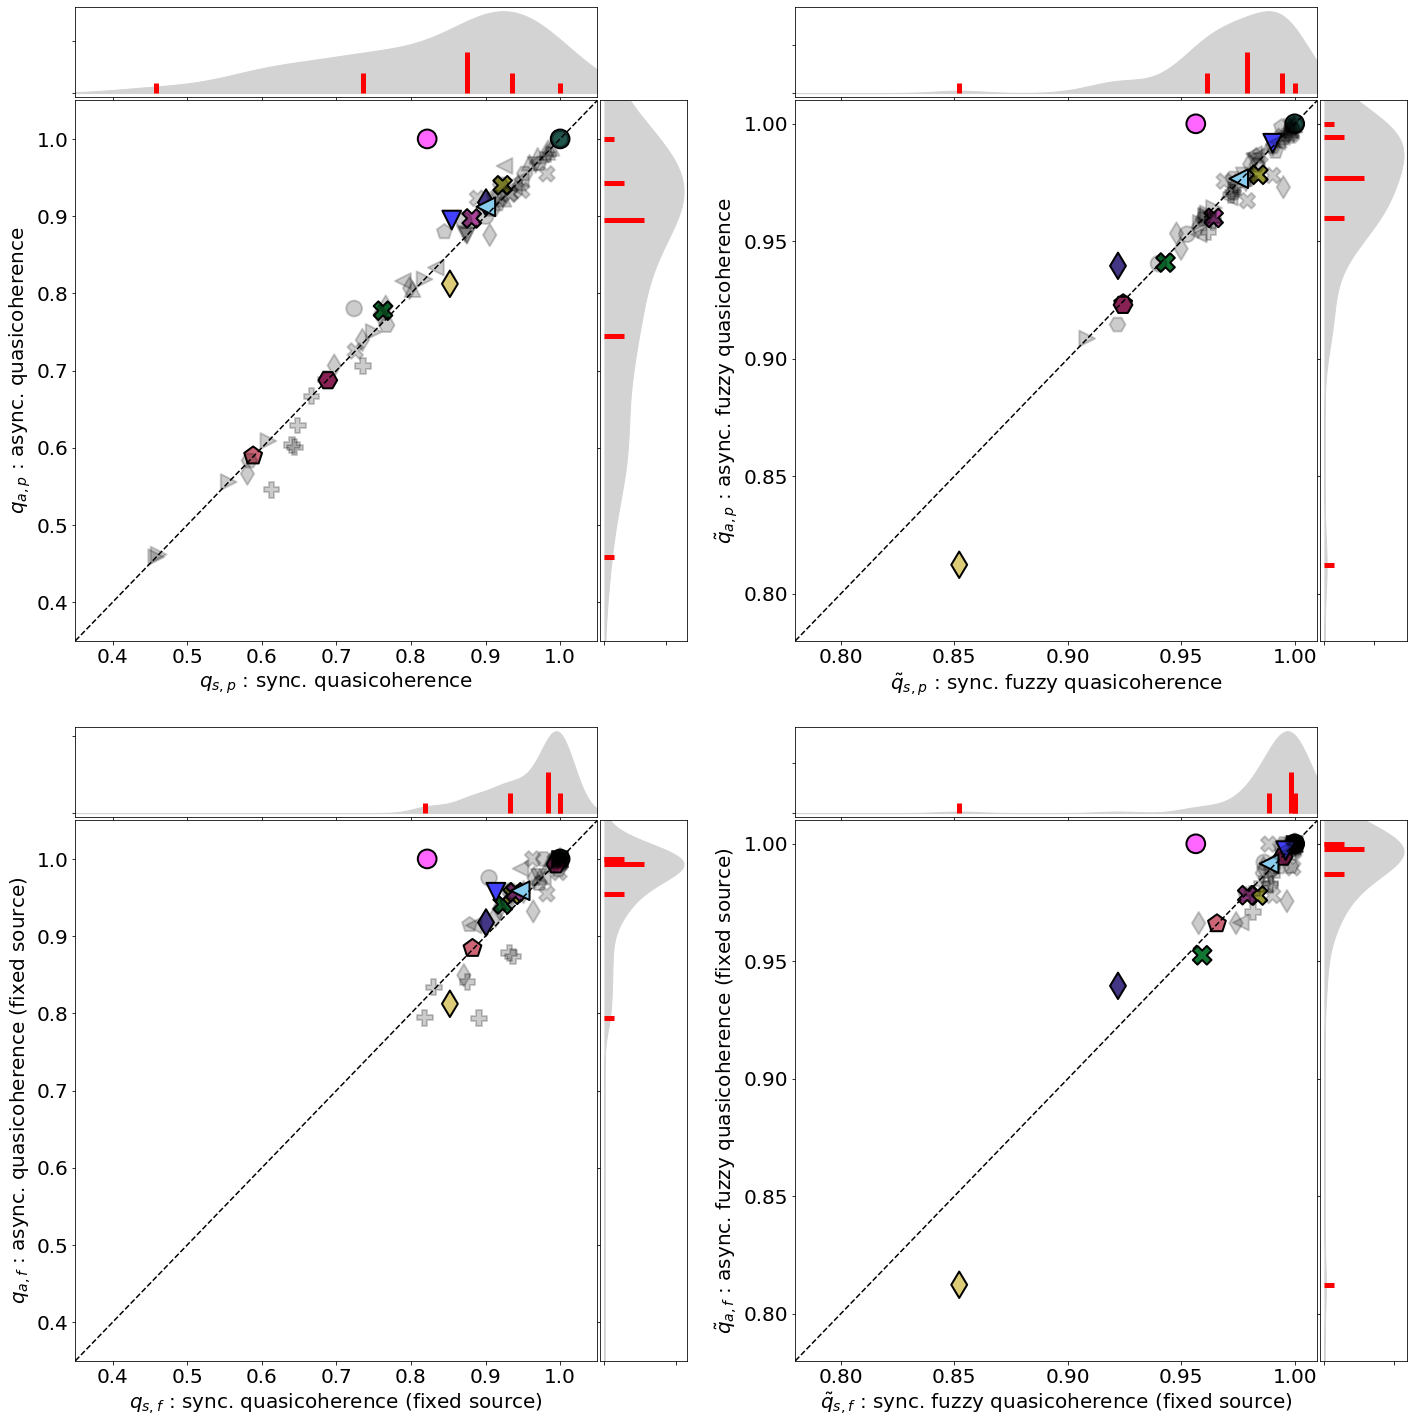

In [8]:
vars = [
    [
        (PlotVar('SQC',0.35,1.05),PlotVar('AQC',0.35,1.05)),
        (PlotVar('SFQC',0.78,1.01),PlotVar('AFQC',0.78,1.01)),
    ],
    [
        (PlotVar('SQCNS',0.35,1.05),PlotVar('AQCNS',0.35,1.05)),
        (PlotVar('SFQCNS',0.78,1.01),PlotVar('AFQCNS',0.78,1.01)), 
    ],
]

fig = comparison_plots(vars)
fig.savefig(f'./data/{models_dir}/figures/quasicoherence_comparisons.png',bbox_inches='tight')
fig.savefig(f'./data/{models_dir}/figures/quasicoherence_comparisons.pdf',bbox_inches='tight')

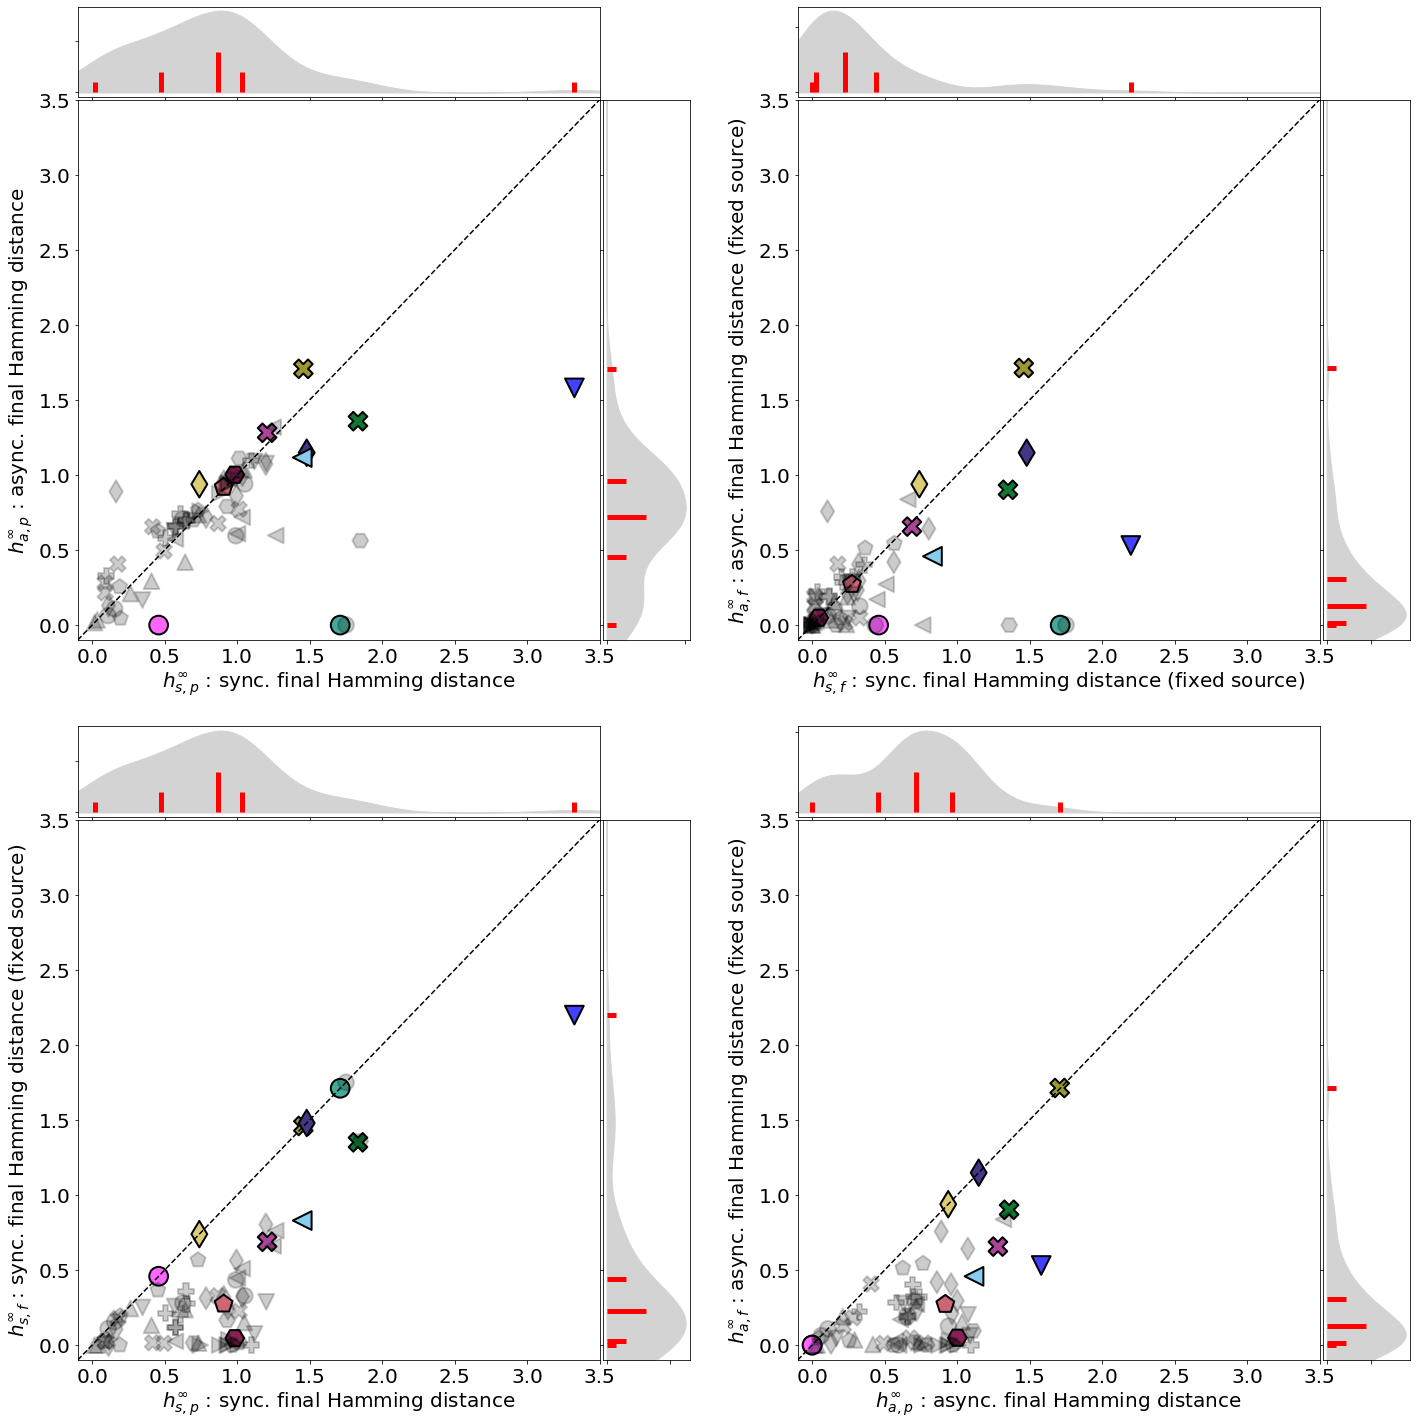

In [9]:
vars = [
    [
        (PlotVar('SFHD',-0.1,3.5),PlotVar('AFHD',-0.1,3.5)),
        (PlotVar('SFHDNS',-0.1,3.5),PlotVar('AFHDNS',-0.1,3.5)),
    ],
    [
        (PlotVar('SFHD',-0.1,3.5),PlotVar('SFHDNS',-0.1,3.5)),
        (PlotVar('AFHD',-0.1,3.5),PlotVar('AFHDNS',-0.1,3.5)), 
    ],
]

fig = comparison_plots(vars)
fig.savefig(f'./data/{models_dir}/figures/Hamming_comparison.png',bbox_inches='tight')
fig.savefig(f'./data/{models_dir}/figures/Hamming_comparison.pdf',bbox_inches='tight')

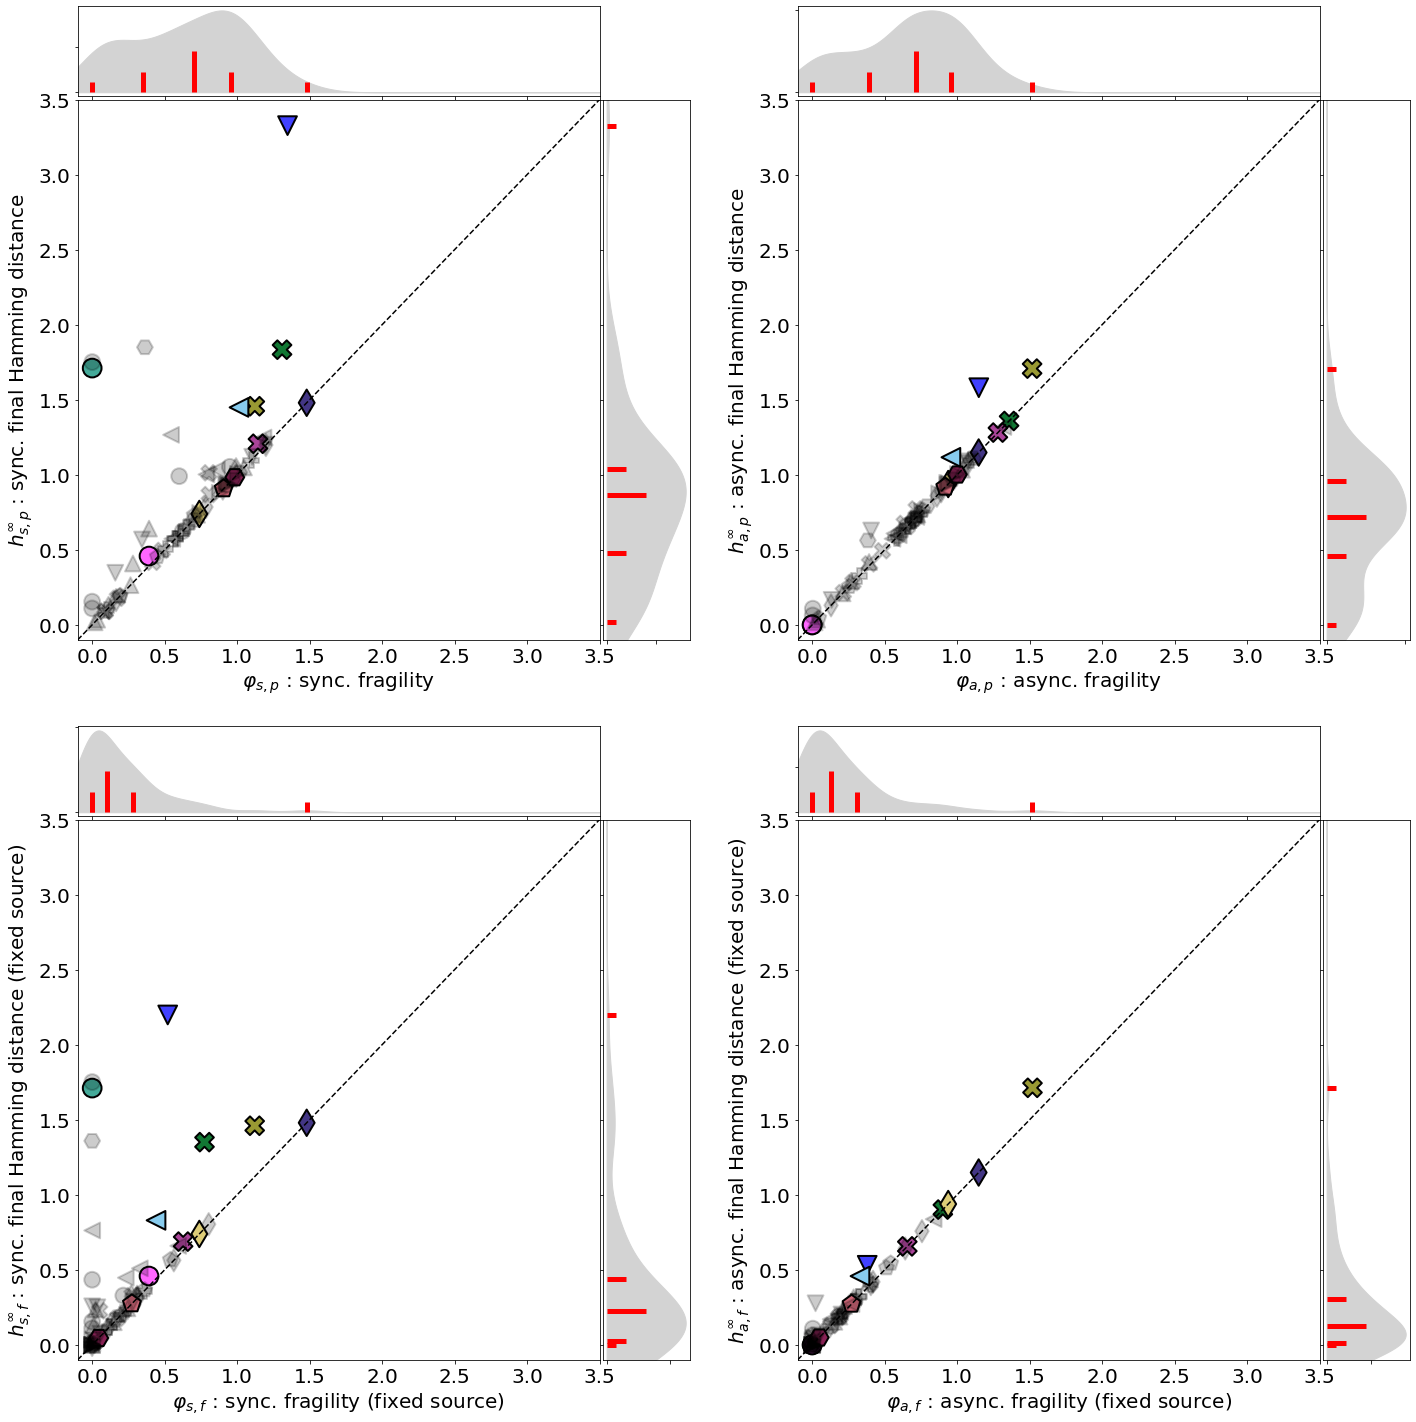

In [10]:
vars = [
    [
        (PlotVar('SF',-0.1,3.5),PlotVar('SFHD',-0.1,3.5)),
        (PlotVar('AF',-0.1,3.5),PlotVar('AFHD',-0.1,3.5)),
    ],
    [
        (PlotVar('SFNS',-0.1,3.5),PlotVar('SFHDNS',-0.1,3.5)),
        (PlotVar('AFNS',-0.1,3.5),PlotVar('AFHDNS',-0.1,3.5)), 
    ],
]

fig = comparison_plots(vars)
fig.savefig(f'./data/{models_dir}/figures/Hamming-Fragility.png',bbox_inches='tight')
fig.savefig(f'./data/{models_dir}/figures/Hamming-Fragility.pdf',bbox_inches='tight')

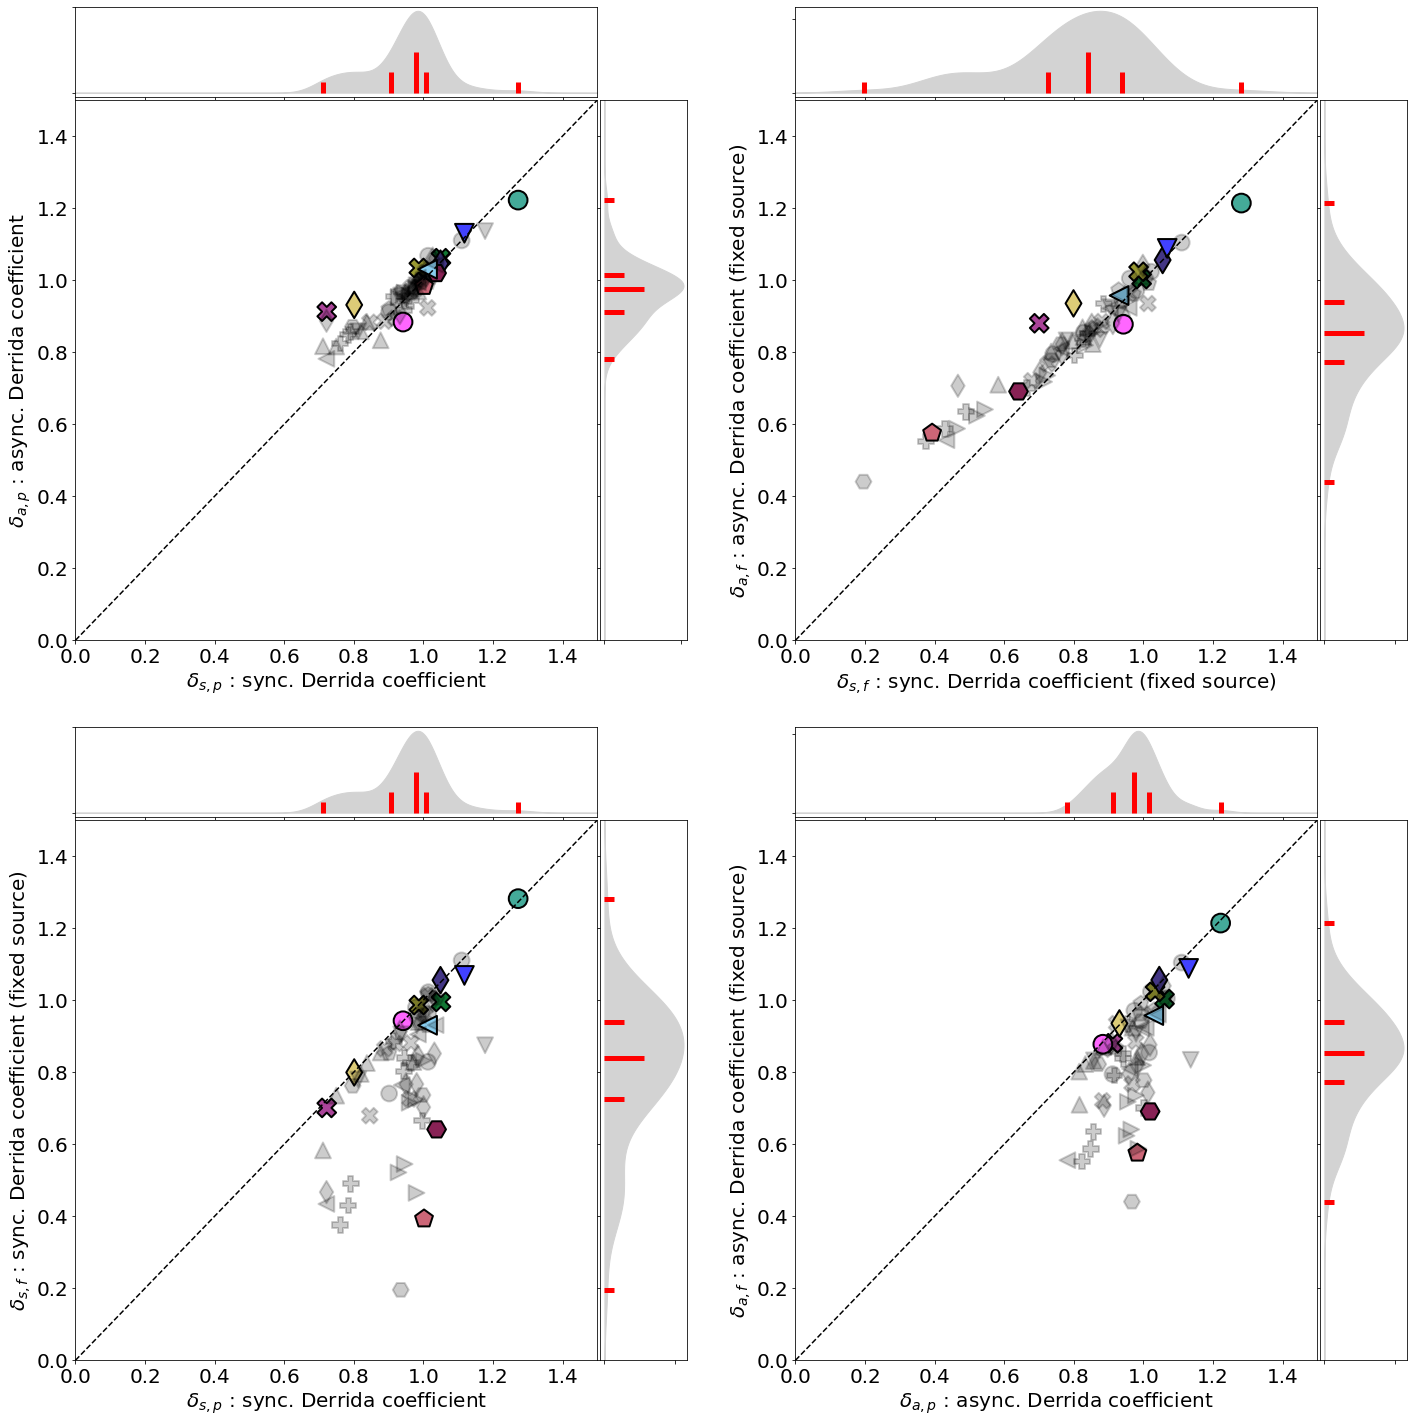

In [11]:
vars = [
    [
        (PlotVar('SDC',0.0,1.5),PlotVar('ADC',0.0,1.5)),
        (PlotVar('SDCNS',0.0,1.5),PlotVar('ADCNS',0.0,1.5)),
    ],
    [
        (PlotVar('SDC',0.0,1.5),PlotVar('SDCNS',0.0,1.5)),
        (PlotVar('ADC',0.0,1.5),PlotVar('ADCNS',0.0,1.5)), 
    ],
]

fig = comparison_plots(vars)
fig.savefig(f'./data/{models_dir}/figures/Derrida_comparison.png',bbox_inches='tight')
fig.savefig(f'./data/{models_dir}/figures/Derrida_comparison.pdf',bbox_inches='tight')

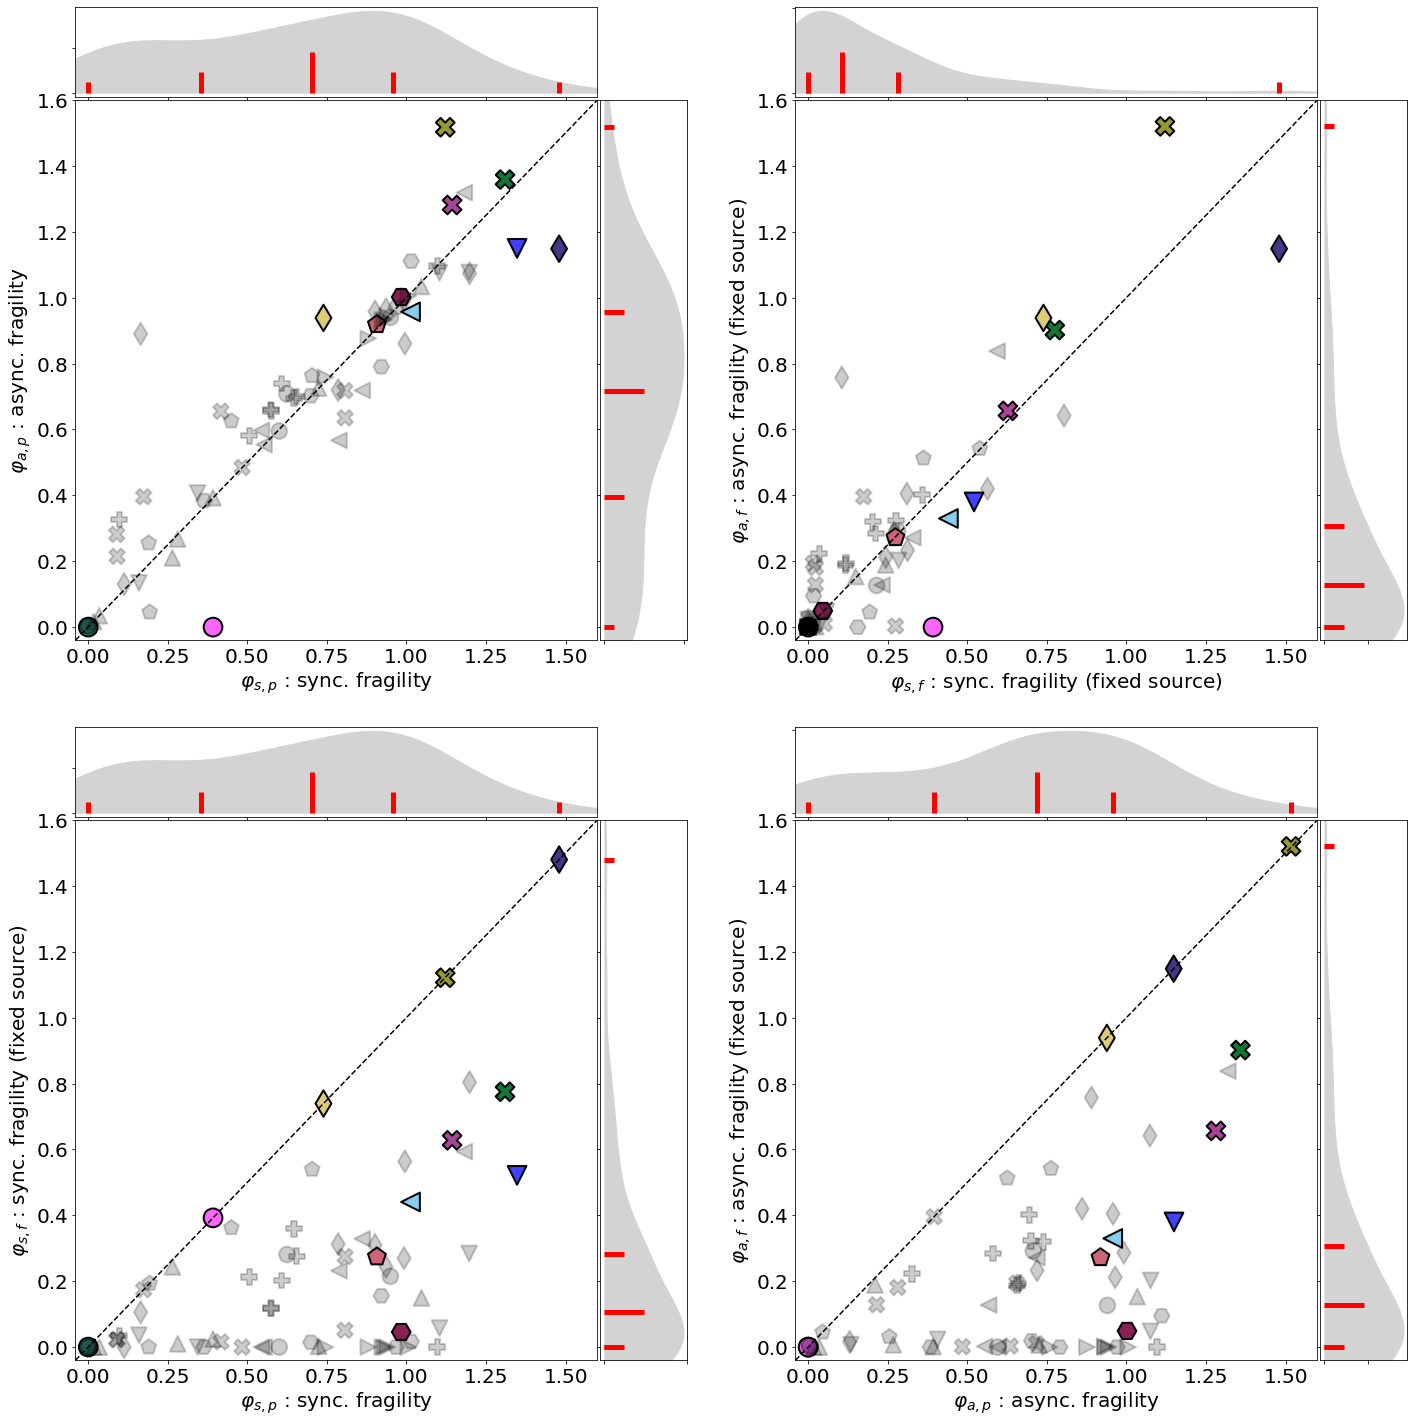

In [12]:
vars = [
    [
        (PlotVar('SF',-0.04,1.6),PlotVar('AF',-0.04,1.6)),
        (PlotVar('SFNS',-0.04,1.6),PlotVar('AFNS',-0.04,1.6)),
    ],
    [
        (PlotVar('SF',-0.04,1.6),PlotVar('SFNS',-0.04,1.6)),
        (PlotVar('AF',-0.04,1.6),PlotVar('AFNS',-0.04,1.6)), 
    ],
]

fig = comparison_plots(vars)
fig.savefig(f'./data/{models_dir}/figures/fragility_comparison.png',bbox_inches='tight')
fig.savefig(f'./data/{models_dir}/figures/fragility_comparison.pdf',bbox_inches='tight')

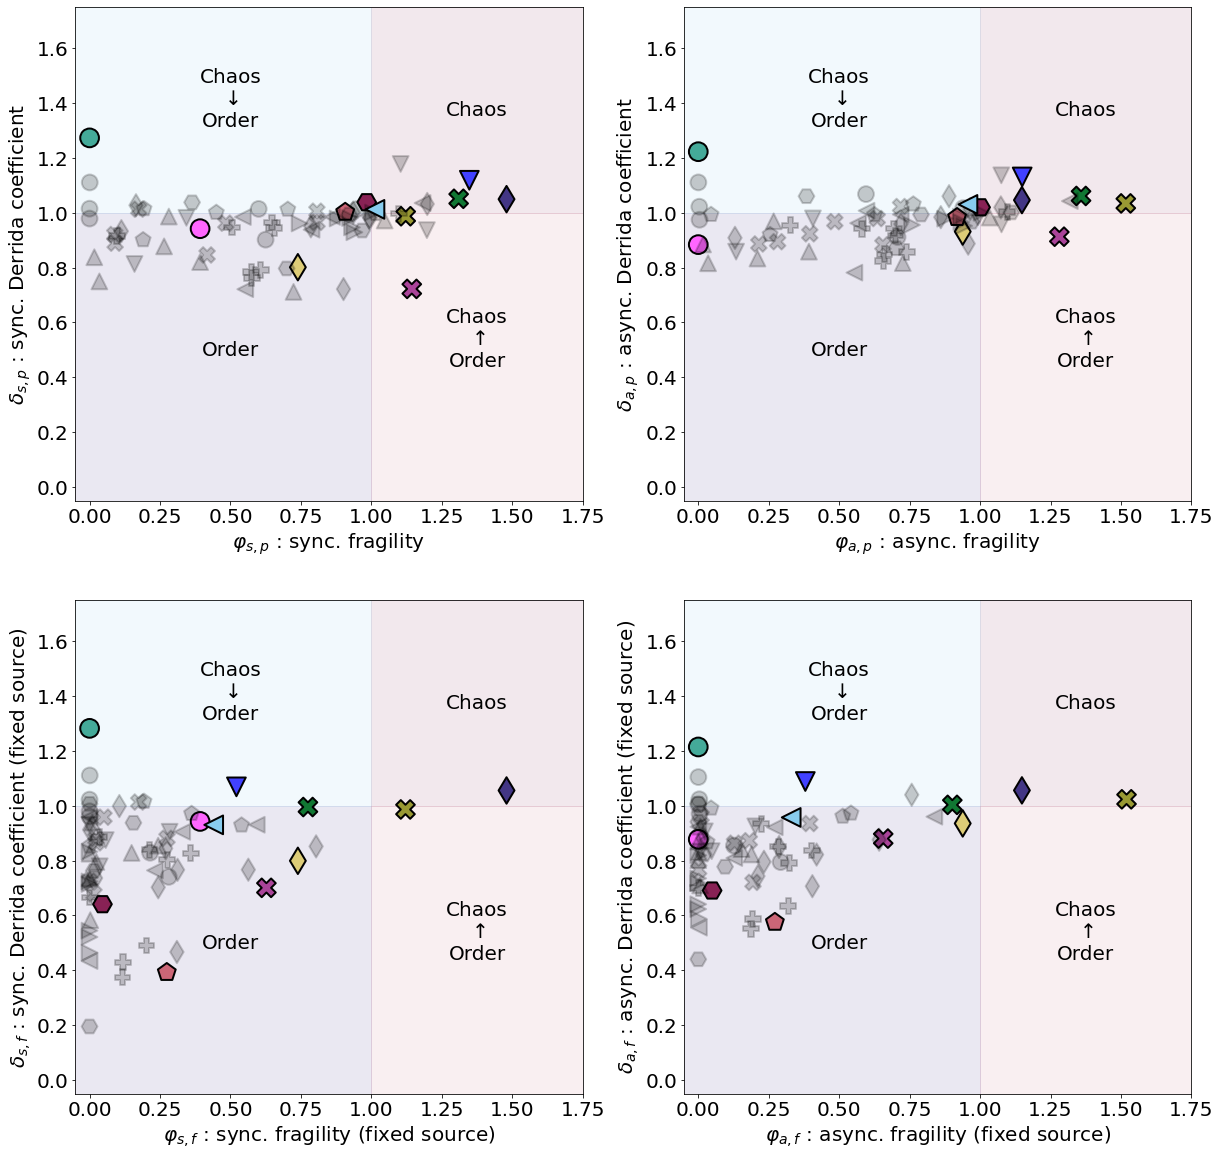

In [13]:
region_alpha = 0.1
cmap = plt.cm.get_cmap('coolwarm')
minval = -0.05
maxval = 1.75
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    # color_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD'] # tol_muted scheme
    regions = [
        Rectangle((minval,minval),1-minval,1-minval,color='#332288',alpha=region_alpha),
        Rectangle((1,1),maxval-1,maxval-1,color='#882255',alpha=region_alpha),
        Rectangle((minval,1),1-minval,maxval-1,color='#88CCEE',alpha=region_alpha),
        Rectangle((1,minval),maxval-1,1-minval,color='#CC6677',alpha=region_alpha),
        ]
    for r in regions:
        sub_ax.add_patch(r)
        
    sub_ax.annotate(('Chaos\n'+r'$\downarrow$'+'\nOrder\n'),xy=(0.5,1.375),ha='center',va='center')
    sub_ax.annotate('Order',xy=(0.5,0.5),ha='center',va='center')
    sub_ax.annotate(('Chaos\n'+r'$\uparrow$'+'\nOrder\n'),xy=(1.375,0.5),ha='center',va='center')
    sub_ax.annotate('Chaos',xy=(1.375,1.375),ha='center',va='center')
for name,group in groups:
    ax[0,0].scatter(group['SF'],group['SDC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SF'],QC['SDC'],c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel(r'$\varphi_{s,p}$ : sync. fragility')
ax[0,0].set_ylabel(r'$\delta_{s,p}$ : sync. Derrida coefficient')
ax[0,0].set_xlim(minval,maxval)
ax[0,0].set_ylim(minval,maxval)

for name,group in groups:
    ax[0,1].scatter(group['AF'],group['ADC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['AF'],QC['ADC'],c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel(r'$\varphi_{a,p}$ : async. fragility')
ax[0,1].set_ylabel(r'$\delta_{a,p}$ : async. Derrida coefficient')
ax[0,1].set_xlim(minval,maxval)
ax[0,1].set_ylim(minval,maxval)

for name,group in groups:
    ax[1,0].scatter(group['SFNS'],group['SDCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SFNS'],QC['SDCNS'], c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel(r'$\varphi_{s,f}$ : sync. fragility (fixed source)')
ax[1,0].set_ylabel(r'$\delta_{s,f}$ : sync. Derrida coefficient (fixed source)')
ax[1,0].set_xlim(minval,maxval)
ax[1,0].set_ylim(minval,maxval)

for name,group in groups:
    ax[1,1].scatter(group['AFNS'],group['ADCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AFNS'],QC['ADCNS'],c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel(r'$\varphi_{a,f}$ : async. fragility (fixed source)')
ax[1,1].set_ylabel(r'$\delta_{a,f}$ : async. Derrida coefficient (fixed source)')
ax[1,1].set_xlim(minval,maxval)
ax[1,1].set_ylim(minval,maxval)


plt.savefig(f'./data/{models_dir}/figures/Derrida-Fragility.png')
plt.savefig(f'./data/{models_dir}/figures/Derrida-Fragility.pdf')
plt.show()

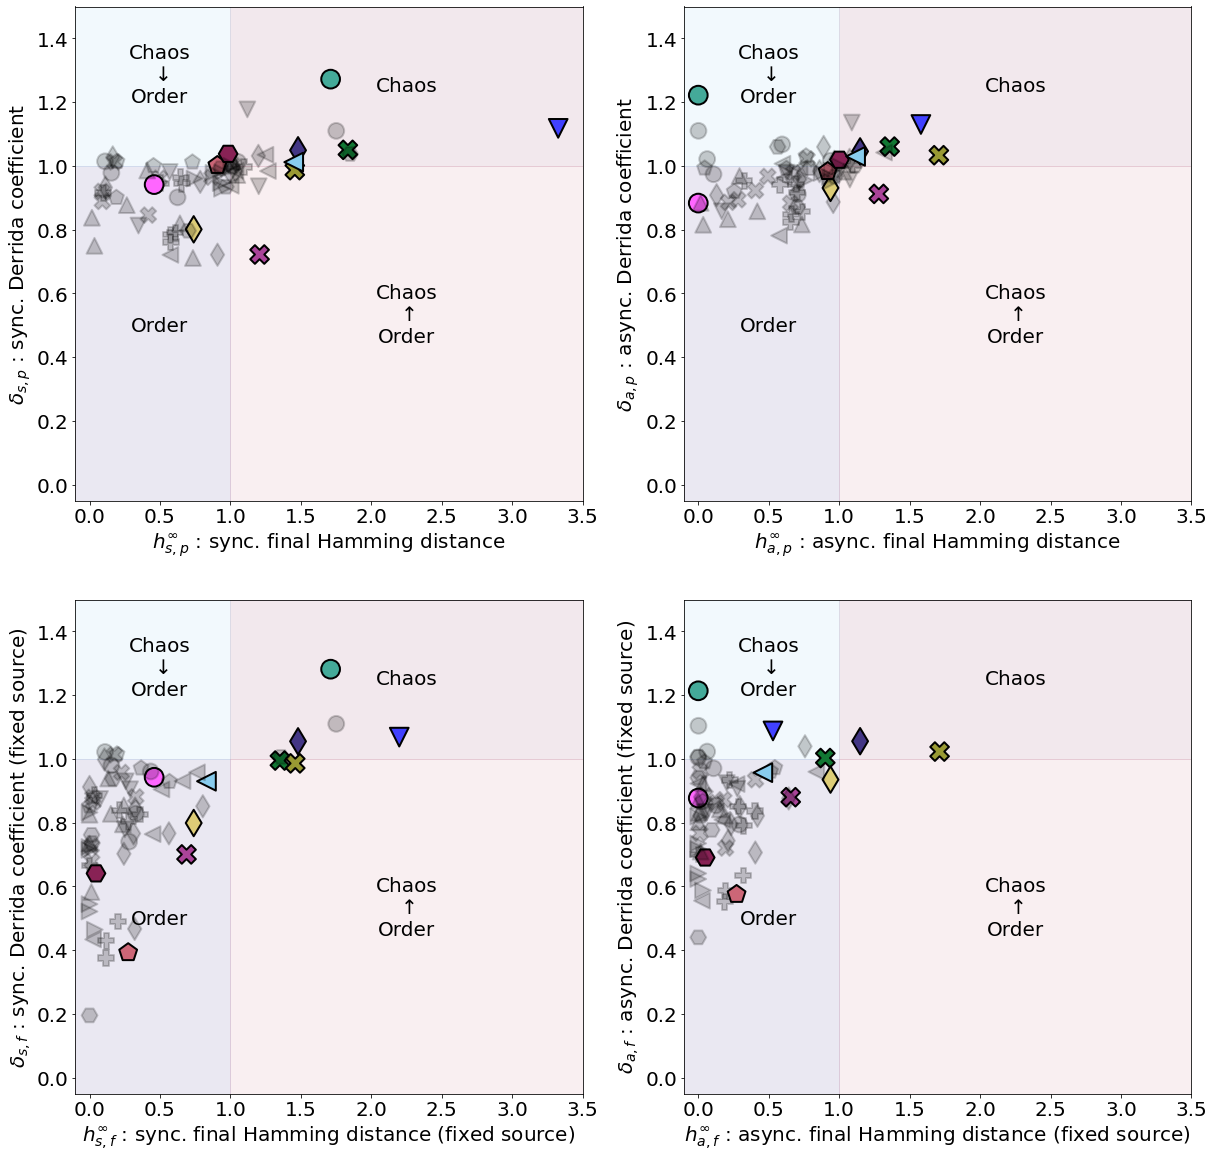

In [14]:
region_alpha = 0.1
cmap = plt.cm.get_cmap('coolwarm')
minvalx = -0.1
minvaly = -0.05
maxvalx = 3.5
maxvaly = 1.5
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    regions = [
        Rectangle((minvalx,minvaly),1-minvalx,1-minvaly,color='#332288',alpha=region_alpha),
        Rectangle((1,1),maxvalx-1,maxvaly-1,color='#882255',alpha=region_alpha),
        Rectangle((minvalx,1),1-minvalx,maxvalx-1,color='#88CCEE',alpha=region_alpha),
        Rectangle((1,minvaly),maxvalx-1,1-minvaly,color='#CC6677',alpha=region_alpha),
        ]
    for r in regions:
        sub_ax.add_patch(r)
        
    sub_ax.annotate(('Chaos\n'+r'$\downarrow$'+'\nOrder\n'),xy=(0.5,1.25),ha='center',va='center')
    sub_ax.annotate('Order',xy=(0.5,0.5),ha='center',va='center')
    sub_ax.annotate(('Chaos\n'+r'$\uparrow$'+'\nOrder\n'),xy=(2.25,0.5),ha='center',va='center')
    sub_ax.annotate('Chaos',xy=(2.25,1.25),ha='center',va='center')

for name,group in groups:
    ax[0,0].scatter(group['SFHD'],group['SDC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SFHD'],QC['SDC'],c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel(r'$h^{\infty}_{s,p}$ : sync. final Hamming distance')
ax[0,0].set_ylabel(r'$\delta_{s,p}$ : sync. Derrida coefficient')
ax[0,0].set_xlim(minvalx,maxvalx)
ax[0,0].set_ylim(minvaly,maxvaly)

for name,group in groups:
    ax[0,1].scatter(group['AFHD'],group['ADC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['AFHD'],QC['ADC'],c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel(r'$h^{\infty}_{a,p}$ : async. final Hamming distance')
ax[0,1].set_ylabel(r'$\delta_{a,p}$ : async. Derrida coefficient')
ax[0,1].set_xlim(minvalx,maxvalx)
ax[0,1].set_ylim(minvaly,maxvaly)

for name,group in groups:
    ax[1,0].scatter(group['SFHDNS'],group['SDCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SFHDNS'],QC['SDCNS'],c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel(r'$h^{\infty}_{s,f}$ : sync. final Hamming distance (fixed source)')
ax[1,0].set_ylabel(r'$\delta_{s,f}$ : sync. Derrida coefficient (fixed source)')
ax[1,0].set_xlim(minvalx,maxvalx)
ax[1,0].set_ylim(minvaly,maxvaly)

for name,group in groups:
    ax[1,1].scatter(group['AFHDNS'],group['ADCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AFHDNS'],QC['ADCNS'],c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel(r'$h^{\infty}_{a,f}$ : async. final Hamming distance (fixed source)')
ax[1,1].set_ylabel(r'$\delta_{a,f}$ : async. Derrida coefficient (fixed source)')
ax[1,1].set_xlim(minvalx,maxvalx)
ax[1,1].set_ylim(minvaly,maxvaly)



plt.savefig(f'./data/{models_dir}/figures/Derrida-Hamming.png')
plt.savefig(f'./data/{models_dir}/figures/Derrida-Hamming.pdf')
plt.show()